# Nets vs Derms using TF Shards of test sets


In [1]:
from datetime import datetime
import math
import os.path
import time
from sklearn.metrics import average_precision_score, roc_curve, auc

import numpy as np
import tensorflow as tf

from inception import image_processing
from inception import inception_model as inception
from inception.skin_data import SkinData

import lib 
from lib.learning import vis_utils as vu
from lib.learning import clumping_utils as cu


In [2]:
FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string('eval_dir', '/archive/esteva/experiments/skindata4/baseline/eval',
                           """Directory where to write event logs.""")
tf.app.flags.DEFINE_string('checkpoint_dir', '/archive/esteva/experiments/skindata4/baseline/train',
                           """Directory where to read model checkpoints.""")
tf.app.flags.DEFINE_string('labels_file', '/archive/esteva/skindata4/splits/nine-way/labels.txt',
                           """The file with the classnames listed in it.""")


# Flags governing the data used for the eval.
tf.app.flags.DEFINE_integer('num_examples', 14712,
                            """Number of examples to run. Note that the connected componenets"""
                            """validation dataset contains 14709 examples.""")
tf.app.flags.DEFINE_string('subset', 'validation',
                           """Either 'validation' or 'train'.""")

tf.app.flags.DEFINE_string('mapping_file',
                           '',
                           """Defines a mapping from train to validation indicating how classes will be merged."""
                           """If this is specified, we sum probabilities to the validation class level."""
                           """Entries in this file must be of the form:
                                [validation-class-0] [training-class-0]
                                [validation-class-0] [training-class-1]
                                [validation-class-0] [training-class-2]
                                [validation-class-1] [training-class-3]
                                ...
                           """
                           )


In [3]:
def _eval_once(saver, softmax_op, labels_op, num_classes):
    """Runs Eval once.

    Args:
    saver: Saver.        
    softmax_op: The softmax op
    labels_op: The labels op    
    num_classes: the number of classes in the dataset (including background class)
    """
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state(FLAGS.checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            if os.path.isabs(ckpt.model_checkpoint_path):
                # Restores from checkpoint with absolute path.
                saver.restore(sess, ckpt.model_checkpoint_path)
            else:
                # Restores from checkpoint with relative path.
                saver.restore(sess, os.path.join(FLAGS.checkpoint_dir,
                                                 ckpt.model_checkpoint_path))

            # Assuming model_checkpoint_path looks something like:
            #   /my-favorite-path/imagenet_train/model.ckpt-0,
            # extract global_step from it.
            global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
            print('Succesfully loaded model from %s at step=%s.' %
                (ckpt.model_checkpoint_path, global_step))
        else:
            print('No checkpoint file found')
            return

        # Start the queue runners.
        coord = tf.train.Coordinator()
        try:
            threads = []
            for qr in tf.get_collection(tf.GraphKeys.QUEUE_RUNNERS):
                threads.extend(qr.create_threads(sess, coord=coord, daemon=True,
                                             start=True))

            num_iter = int(math.ceil(FLAGS.num_examples / FLAGS.batch_size))
            # Counts the number of correct predictions.        
            total_sample_count = num_iter * FLAGS.batch_size
            step = 0
            correct_per_class = np.zeros(num_classes)
            count_per_class = np.zeros(num_classes)

            mapping = ['__unused_background_class__ __unused_background_class__']
            _mapping = [line.strip() for line in open(FLAGS.mapping_file).readlines()]
            mapping.extend(_mapping)
            val_classes = np.unique([m.split()[0] for m in mapping])
            num_val_classes = len(val_classes)
            correct_per_class = np.zeros(num_val_classes)
            count_per_class = np.zeros(num_val_classes)

            print('%s: starting evaluation on (%s).' % (datetime.now(), FLAGS.subset))
            start_time = time.time()
            total_softmax = []
            all_labels = []
            while step < num_iter and not coord.should_stop():
                softmax, labels = sess.run([softmax_op, labels_op])
                all_labels.append(labels)
                if FLAGS.mapping_file:
                    softmax = cu.mergeProbabilities(softmax, mapping)
                total_softmax.append(softmax)

                step += 1
                if step % 20 == 0:
                    duration = time.time() - start_time
                    sec_per_batch = duration / 20.0
                    examples_per_sec = FLAGS.batch_size / sec_per_batch
                    print('%s: [%d batches out of %d] (%.1f examples/sec; %.3f'
                        'sec/batch)' % (datetime.now(), step, num_iter,
                                        examples_per_sec, sec_per_batch))
                    start_time = time.time()

        except Exception as e:  # pylint: disable=broad-except
            coord.request_stop(e)

        coord.request_stop()
        coord.join(threads, stop_grace_period_secs=10)
    
    return np.vstack(total_softmax), np.hstack(all_labels)


In [4]:
def evaluate(dataset):
    """Evaluate model on Dataset for a number of steps."""
    with tf.Graph().as_default():
        # Get images and labels from the dataset.
        images, labels = image_processing.inputs(dataset)

        # Number of classes in the Dataset label set plus 1.
        # Label 0 is reserved for an (unused) background class.
        num_classes = dataset.num_classes() + 1

        # Build a Graph that computes the logits predictions from the
        # inference model.
        logits, _ = inception.inference(images, num_classes)
        softmax = tf.nn.softmax(logits)   

        # Restore the moving average version of the learned variables for eval.
        variable_averages = tf.train.ExponentialMovingAverage(
            inception.MOVING_AVERAGE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)

        probabilities, labels = _eval_once(saver, softmax, labels, num_classes)
    return probabilities, labels
    
    
def plot_results(labels, probs, people, title, show_legend=False, return_fig_handle=False, textcolor='#4D5B66'):
    """Plots the SS and prints best results for the data, given the extracted probs."""

    fpr, tpr, thresholds = roc_curve(labels, probs)
    tnr = 1 - fpr
    ss = np.concatenate((tpr.reshape((-1,1)), tnr.reshape((-1,1)), thresholds.reshape((-1,1))), axis=1)
    best = np.argmax(np.mean(ss[:, :2], axis=1))
    best_sens = ss[best, 0]
    best_spec = ss[best, 1]
    best_thresh = ss[best, 2]
    auc_ss = auc(fpr, tpr)

    print 'Best sens', best_sens
    print 'Best spec', best_spec
    print 'Best thresh', best_thresh
    fig, ax = vu.plotSSCurve(tpr, tnr, people=people, title=title, show_legend=show_legend, textcolor=textcolor)
    if return_fig_handle:
        return fig, ax

### Epidermal Test

In [5]:
FLAGS.eval_dir = '/tmp/eval'
FLAGS.checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/nine-way/train/'
FLAGS.labels_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/nine-way/labels.txt'
FLAGS.num_examples = 707
FLAGS.data_dir = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/tf_shards/tests/epidermal_test/'
FLAGS.mapping_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/nine-way/labels.txt.mappingEpidermal'

In [5]:
FLAGS.eval_dir = '/tmp/eval'
FLAGS.checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/recursive_dividing_N=1000/train/'
FLAGS.labels_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/recursive_dividing_N=1000/labels.txt'
FLAGS.num_examples = 707
FLAGS.data_dir = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/tf_shards/tests/epidermal_test/'
FLAGS.mapping_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/recursive_dividing_N=1000/labels.txt.mappingEpidermal'

In [6]:
num_classes = len([line for line in open(FLAGS.labels_file).readlines() if line.strip()])
dataset = SkinData(subset=FLAGS.subset, num_classes=num_classes)
assert dataset.data_files()

print('Using mapping file %s' % FLAGS.mapping_file)
mapping = [line.strip().split()[1] for line in open(FLAGS.mapping_file).readlines()]
synset = [line.strip() for line in open(FLAGS.labels_file).readlines()]

assert len(mapping) == len(synset), \
      'Length of mapping & synset do not match: %s, %s' % (FLAGS.mapping_file, FLAGS.labels_file)
for i, (m,s) in enumerate(zip(mapping, synset)):
    assert m == s, 'Mapping issue entry %d, %s is not %s' % (i, m, s)

t = time.time()
probabilities, labels = evaluate(dataset)
print 'Elapsed Tine %0.2f' % (time.time() - t)


Using mapping file /media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/nine-way/labels.txt.mappingEpidermal
Succesfully loaded model from model.ckpt-165000 at step=165000.
2016-07-19 10:26:40.185801: starting evaluation on (validation).
2016-07-19 10:26:53.898963: [20 batches out of 22] (46.7 examples/sec; 0.686sec/batch)
Elapsed Tine 24.31


Best sens 0.854910714286
Best spec 0.9296875
Best thresh 0.813561625575
The AUC is 0.94868687221


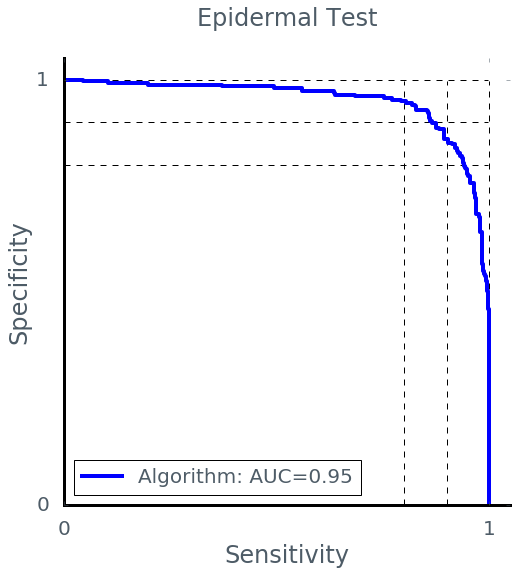

In [8]:
p = probabilities.copy()
p = p[:, 1:]
p /= np.sum(p, axis=1).reshape((-1,1))
p = p[:,1]
l = labels - 1


f, a = plot_results(l, p, [], 'Epidermal Test', show_legend=True, return_fig_handle=True)

In [12]:
f.savefig('/tmp/epi.svg')

### Pigmented Test

In [73]:
FLAGS.eval_dir = '/tmp/eval'
FLAGS.checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/nine-way/train/'
FLAGS.labels_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/nine-way/labels.txt'
FLAGS.num_examples = 225
FLAGS.data_dir = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/tf_shards/tests/melanocytic_test/'
FLAGS.mapping_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/nine-way/labels.txt.mappingMelanocytic'

In [54]:
FLAGS.eval_dir = '/tmp/eval'
FLAGS.checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/recursive_dividing_N=1000/train/'
FLAGS.labels_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/recursive_dividing_N=1000/labels.txt'
FLAGS.num_examples = 225
FLAGS.data_dir = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/tf_shards/tests/melanocytic_test/'
FLAGS.mapping_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/recursive_dividing_N=1000/labels.txt.mappingMelanocytic'

In [74]:
num_classes = len([line for line in open(FLAGS.labels_file).readlines() if line.strip()])
dataset = SkinData(subset=FLAGS.subset, num_classes=num_classes)
assert dataset.data_files()

print('Using mapping file %s' % FLAGS.mapping_file)
mapping = [line.strip().split()[1] for line in open(FLAGS.mapping_file).readlines()]
synset = [line.strip() for line in open(FLAGS.labels_file).readlines()]

assert len(mapping) == len(synset), \
      'Length of mapping & synset do not match: %s, %s' % (FLAGS.mapping_file, FLAGS.labels_file)
for i, (m,s) in enumerate(zip(mapping, synset)):
    assert m == s, 'Mapping issue entry %d, %s is not %s' % (i, m, s)

t = time.time()
probabilities, labels = evaluate(dataset)
print 'Elapsed Tine %0.2f' % (time.time() - t)


Using mapping file /media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/nine-way/labels.txt.mappingMelanocytic
Succesfully loaded model from model.ckpt-165000 at step=165000.
2016-07-18 18:52:15.500774: starting evaluation on (validation).


KeyboardInterrupt: 

In [ ]:
p = probabilities.copy()
p = p[:, 1:]
p /= np.sum(p, axis=1).reshape((-1,1))
p = p[:,1]
l = labels - 1


plot_results(l, p, [], 'Melanocytic Test', show_legend=True)

### Dermoscopy Test

In [70]:
FLAGS.eval_dir = '/tmp/eval'
FLAGS.checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/nine-way/train/'
FLAGS.labels_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/nine-way/labels.txt'
FLAGS.num_examples = 1010
FLAGS.data_dir = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/tf_shards/tests/dermoscopy_test/'
FLAGS.mapping_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/nine-way/labels.txt.mappingMelanocytic'

In [48]:
FLAGS.eval_dir = '/tmp/eval'
FLAGS.checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/recursive_dividing_N=1000/train/'
FLAGS.labels_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/recursive_dividing_N=1000/labels.txt'
FLAGS.num_examples = 1010
FLAGS.data_dir = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/tf_shards/tests/dermoscopy_test/'
FLAGS.mapping_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/recursive_dividing_N=1000/labels.txt.mappingDermoscopy'
# FLAGS.mapping_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/recursive_dividing_N=1000/labels.txt.mappingBinary'

In [71]:
num_classes = len([line for line in open(FLAGS.labels_file).readlines() if line.strip()])
dataset = SkinData(subset=FLAGS.subset, num_classes=num_classes)
assert dataset.data_files()

print('Using mapping file %s' % FLAGS.mapping_file)
mapping = [line.strip().split()[1] for line in open(FLAGS.mapping_file).readlines()]
synset = [line.strip() for line in open(FLAGS.labels_file).readlines()]

assert len(mapping) == len(synset), \
      'Length of mapping & synset do not match: %s, %s' % (FLAGS.mapping_file, FLAGS.labels_file)
for i, (m,s) in enumerate(zip(mapping, synset)):
    assert m == s, 'Mapping issue entry %d, %s is not %s' % (i, m, s)

t = time.time()
probabilities, labels = evaluate(dataset)
print 'Elapsed Tine %0.2f' % (time.time() - t)


Using mapping file /media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/nine-way/labels.txt.mappingMelanocytic
Succesfully loaded model from model.ckpt-165000 at step=165000.
2016-07-18 17:41:26.896605: starting evaluation on (validation).
2016-07-18 17:43:36.346789: [20 batches out of 31] (4.9 examples/sec; 6.473sec/batch)
Elapsed Tine 211.20


Best sens 0.883720930233
Best spec 0.934878587196
Best thresh 0.231618366709
The AUC is 0.943811283947


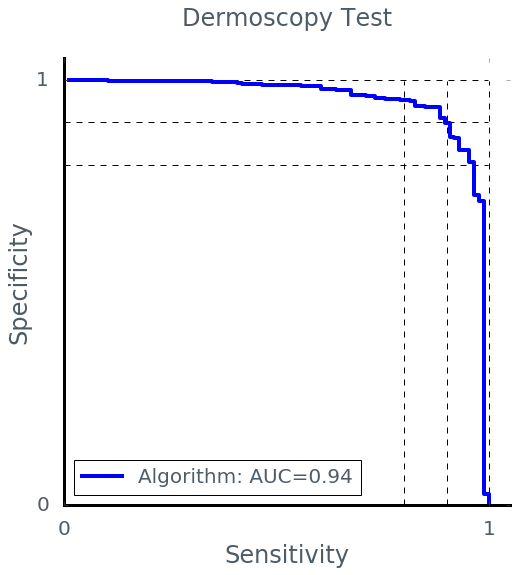

In [72]:
p = probabilities.copy()
p = p[:, 1:]
p /= np.sum(p, axis=1).reshape((-1,1))
p = p[:,1]
l = labels - 1


plot_results(l, p, [], 'Dermoscopy Test', show_legend=True)